In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from load_datasets import load_mnist_imgs_and_labels
import numpy as np

2023-05-16 20:36:42.994449: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# config
batch_size = 128
test_batch_size = 512
epochs = 5
lr = 1e-2
momentum = 0.9
log_interval = 200 # ?
loss_func = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
# from_logits=False in case of softmax activation, =True in any other case
# logits being whot comes out of output neurons after feed forward before applying last activation

# no need to check whether CUDA is used as it is prioritized by default in TensorFlow
# device used printed out at model compilation

In [3]:
x_train, y_train = load_mnist_imgs_and_labels(
	'../datasets/mnist-digits/train-images.idx3-ubyte',
	'../datasets/mnist-digits/train-labels.idx1-ubyte'
)

x_test, y_test = load_mnist_imgs_and_labels(
	'../datasets/mnist-digits/t10k-images.idx3-ubyte',
	'../datasets/mnist-digits/t10k-labels.idx1-ubyte'
)

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(buffer_size=1024).batch(batch_size)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.batch(test_batch_size)

2023-05-16 20:36:58.025114: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-16 20:36:58.344742: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-16 20:36:58.345400: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
class FullyConnectedNet(tf.keras.Model):

	def __init__(self, hidden_layers=[800], num_classes=10):
		super().__init__()
		self.hidden_layers = tf.keras.Sequential([
			tf.keras.layers.Dense(n, activation=tf.nn.relu) for n in hidden_layers
		])
		self.output_layer = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax)
		# TensorFlow best practice is to use softmax activation on last layer
		# combined with *Crossentrpy(from_logits=False) loss function
		# instead of LogSoftmax (like in PyTorch) since NLL loss func is not implemented in TF


	def call(self, x):
		x = self.hidden_layers(x)
		return self.output_layer(x)

# sequential builder, will most probably become obsolete
# since eventually I want to use subclassing api like in PyTorch 
def FullyConnectedNetBuilder(hidden_layers=[800], num_classes=10):
  layers = [tf.keras.layers.Dense(n, activation=tf.nn.relu) for n in hidden_layers]
  layers.append(tf.keras.layers.Dense(num_classes, activation='log_softmax'))
  return tf.keras.Sequential(layers)

In [5]:
model = FullyConnectedNet()

optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum)

model.compile(optimizer=optimizer, loss=loss_func, metrics=['accuracy'])

In [6]:
train_history = model.fit(
	train_ds,
	validation_data=test_ds,
	validation_batch_size=test_batch_size,
	epochs=epochs
)

2023-05-16 20:37:04.395975: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 376320000 exceeds 10% of free system memory.


Epoch 1/5


2023-05-16 20:37:04.638323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [60000,784]
	 [[{{node Placeholder/_0}}]]
2023-05-16 20:37:04.638773: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [60000]
	 [[{{node Placeholder/_1}}]]
2023-05-16 20:37:12.080017: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f3770009c70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-16 20:37:12.080123: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA 

469/469 [==============================] - 12s 3ms/step - loss: 0.5164 - accuracy: 0.8412 - val_loss: 0.3115 - val_accuracy: 0.9085
Epoch 2/5
  1/469 [..............................] - ETA: 2s - loss: 0.3023 - accuracy: 0.9219

2023-05-16 20:37:16.524899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype uint8 and shape [10000]
	 [[{{node Placeholder/_1}}]]


469/469 [==============================] - 1s 2ms/step - loss: 0.3176 - accuracy: 0.9050 - val_loss: 0.2914 - val_accuracy: 0.9139
Epoch 3/5
469/469 [==============================] - 1s 2ms/step - loss: 0.2586 - accuracy: 0.9242 - val_loss: 0.2197 - val_accuracy: 0.9349
Epoch 4/5
469/469 [==============================] - 1s 2ms/step - loss: 0.2153 - accuracy: 0.9378 - val_loss: 0.2090 - val_accuracy: 0.9348
Epoch 5/5
469/469 [==============================] - 1s 2ms/step - loss: 0.1863 - accuracy: 0.9463 - val_loss: 0.1853 - val_accuracy: 0.9430


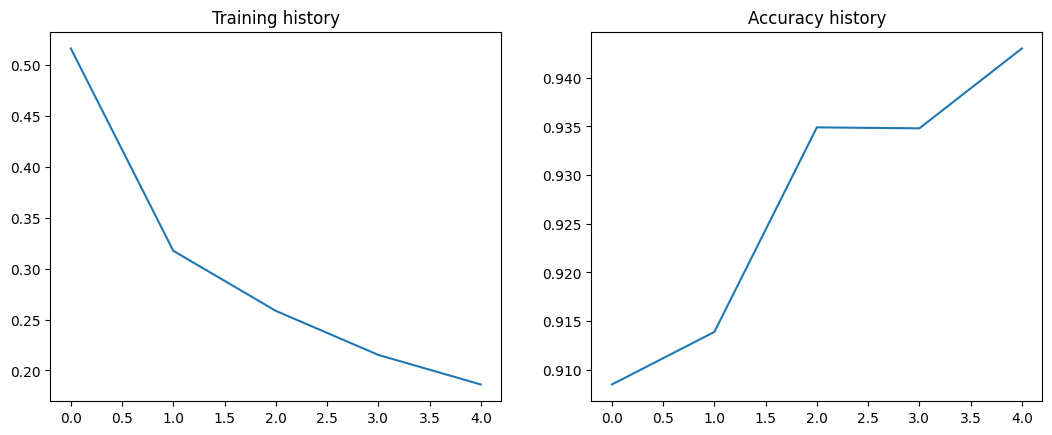

: 

In [7]:
fig, (ax_train, ax_test) = plt.subplots(1, 2)
fig.set_size_inches(12.8, 4.8)

ax_train.plot(train_history.history['loss'])
ax_test.plot(train_history.history['val_accuracy'])
ax_train.set_title('Training history')
ax_test.set_title('Accuracy history')

plt.show(fig)